In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from helpers import log, load_csv, save_csv
#from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
# from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
# from sklearn.feature_selection import SelectKBest, mutual_info_regression
# import xgboost as xgb
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
import seaborn as sns
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import OneHotEncoder
# import optuna

In [2]:
data_directory = "Fantasy-Premier-League/data"
training_data_dir = os.path.join(data_directory, "training_data")
training_file = os.path.join(training_data_dir, "GK_players.csv")
gk_data = load_csv(training_file)
gk_data = gk_data[gk_data["minutes"] >= 60]
gk_data["def_atk_diff"] = gk_data["own_defense"] - gk_data["opponent_attack"]

<Figure size 1400x700 with 0 Axes>

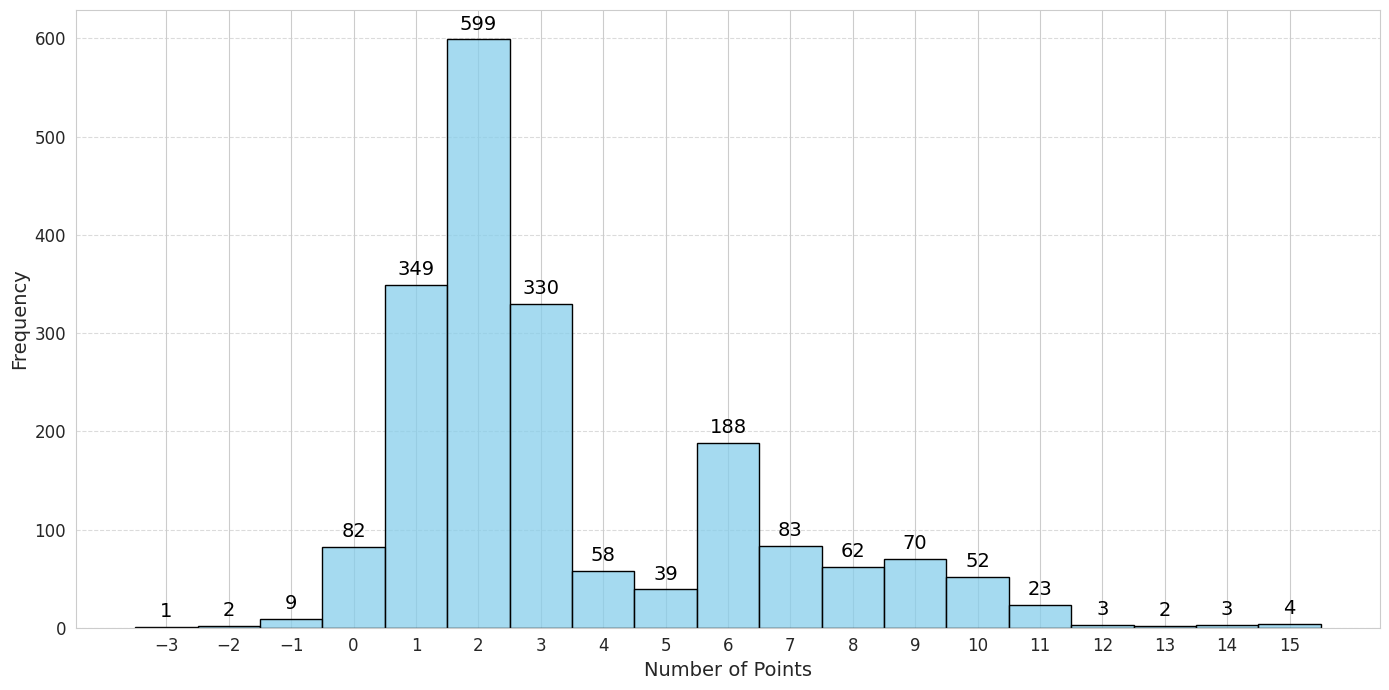

In [3]:
# Plot points for goalkeepers
sns.set_style("whitegrid")

plt.figure(figsize=(14, 7))

min_points = int(gk_data['total_points'].min())
max_points = int(gk_data['total_points'].max())
plt.figure(figsize=(14, 7))
ax = sns.histplot(gk_data['total_points'], bins=range(min_points, max_points + 2), discrete=True, color='skyblue', edgecolor='black')

for patch in ax.patches:
    height = patch.get_height()
    if height > 0: 
        ax.text(
            patch.get_x() + patch.get_width() / 2,
            height + 10,
            f"{int(height)}",
            ha="center",
            fontsize=14,
            color="black"
        )

plt.xlabel("Number of Points", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

plt.xticks(ticks=range(min_points, max_points + 1), fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

In [4]:
stats_points = gk_data["total_points"].describe()
variance = gk_data["total_points"].var()
median_points = gk_data["total_points"].median()

print("Goalkeepers' Points Statistics:")
print(stats_points)
print(f"Variance: {variance:.2f}")
print(f"Median points scored by goalkeepers: {median_points}")

Goalkeepers' Points Statistics:
count    1959.000000
mean        3.430322
std         2.795940
min        -3.000000
25%         2.000000
50%         2.000000
75%         5.500000
max        15.000000
Name: total_points, dtype: float64
Variance: 7.82
Median points scored by goalkeepers: 2.0


In [5]:
rolling_candidates = [
    "bps", "influence", "total_points", "clean_sheets", "yellow_cards", "saves"
]
rolling_periods = [4, 16]

for feature in rolling_candidates:
    for period in rolling_periods:
        sma_column = f"{feature}_rolling_{period}"
        group = gk_data.groupby("Unique_ID")[feature]
        
        gk_data[sma_column] = group.apply(
            lambda x: x.shift(1).rolling(window=period, min_periods=1).mean()
        ).reset_index(level=0, drop=True)

for feature in rolling_candidates:
    for period in rolling_periods:
        sma_column = f"{feature}_rolling_{period}"
        gk_data[sma_column] = gk_data[sma_column].bfill()

other_available = [
    "value", "def_atk_diff",
    "opponent_xG_rolling_4", "opponent_deep_rolling_4",
    "team_xGA_rolling_4",	"team_deep_allowed_rolling_4",
    "opponent_xG_rolling_16",	"opponent_deep_rolling_16",
    "own_defense", "opponent_attack",
    'team_xGA_rolling_16', 'team_deep_allowed_rolling_16'
]
categorical = ["own_team", "opponent_team", "was_home"]

In [6]:
# target = gk_data["total_points"]  # Zmienna docelowa

# possible_features = pd.concat([
#     gk_data[[f"{col}_rolling_{period}" for col in rolling_candidates for period in rolling_periods] + other_available],
# ], axis=1)
# select_k_best = SelectKBest(score_func=lambda X, y: mutual_info_regression(X, y, random_state=42), k=24)
# pipeline = Pipeline([
#     ("select_k_best", select_k_best)
# ])

# pipeline.fit(possible_features, target)

# all_feature_names = possible_features.columns.tolist()

# selected_features = pipeline.named_steps["select_k_best"].get_support(indices=True)

# best_feature_names = [all_feature_names[i] for i in selected_features]
# selected_features = best_feature_names
# print(best_feature_names)

RMSE: 2.7769
MAE: 2.2053


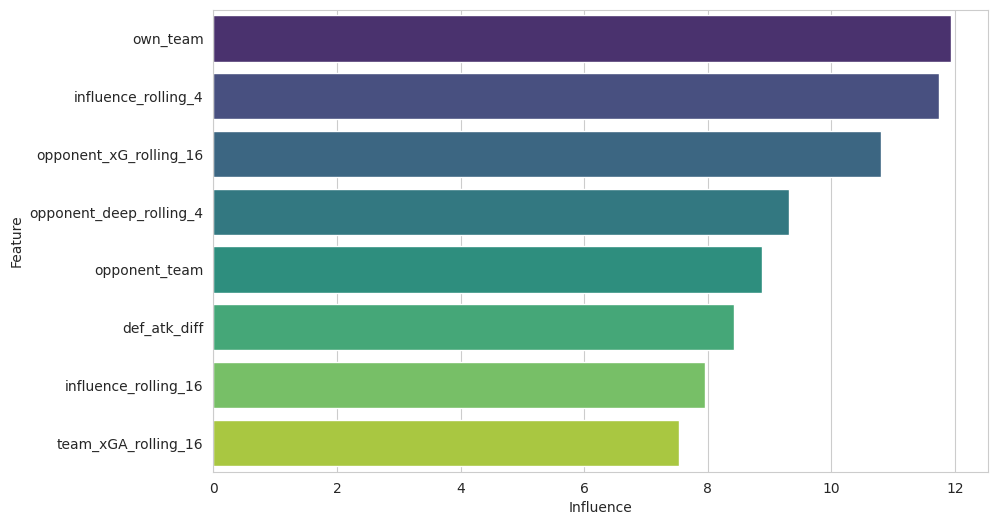

Model saved at: models/gk_prediction_model.json


In [7]:
categorical = ["own_team", "opponent_team", "was_home"]
gk_data[categorical] = gk_data[categorical].astype("category")

selected_features = [
    'bps_rolling_16', 'influence_rolling_4', 'influence_rolling_16', 
    'clean_sheets_rolling_4', 'def_atk_diff', 'opponent_deep_rolling_4', 
    'opponent_xG_rolling_16', 'own_defense', 'team_xGA_rolling_16', 
    'team_deep_allowed_rolling_16'
]

X = pd.concat([gk_data[selected_features], gk_data[categorical]], axis=1)
y = gk_data["total_points"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = CatBoostRegressor(
    iterations=385,
    learning_rate=0.04236843811354502,
    depth=4,
    l2_leaf_reg=1.40390308072213,
    bagging_temperature=5.6007947687582424,
    subsample=0.5014015294545185,
    random_strength=1.4330058141671724,
    random_seed=42,
    verbose=0,
    cat_features=categorical
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

importances = model.get_feature_importance(type='PredictionValuesChange')
feature_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)

top_8_features = feature_importances.head(8)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_8_features.values, y=top_8_features.index, hue=top_8_features.index, palette="viridis", legend=False)
plt.xlabel('Influence')
plt.ylabel('Feature')
plt.show()

models_folder = "models"
os.makedirs(models_folder, exist_ok=True)
model_path = os.path.join(models_folder, "gk_prediction_model.json")
model.save_model(model_path)
print(f"Model saved at: {model_path}")